# Computional Imaging
Arthur Kolodziej, Antoine Lerosey, Luc Ménard, Tom Pégeot

In [1]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import cv2
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

##  I] The two methods

### A) Non-Local Mean

#### i) implementation

In [2]:
def NLM_1channel(noisy,S, s, alpha):
    # works only for a 1 channel image
    """method implemented following the algorithm descibed on https://en.wikipedia.org/wiki/Non-local_means"""
    
    p = S//2
    img = noisy.copy()
    
    h,w = img.shape
    
    # we need to reshape a bit the image to avoid index errors
    p_img = np.zeros((h + S,w + S),dtype ='uint8' ) # we initialize the image
    p_img[p:p+h, p:p+w] = img # the center of this new image is the image noisy
    p_img[p:p+h, 0:p] = np.fliplr(img[:,0:p]) # the part at the left is the reflection of the image
    p_img[p:p+h, w+p:w+2*p] = np.fliplr(img[:,w-p:w]) # same for the tight part
    p_img[0:p,:] = np.flipud(p_img[p:2*p,:]) # and for the top
    p_img[p+h:2*p+h, :] =np.flipud(p_img[p_img.shape[0] - 2*p:p_img.shape[0] - p,:]) # and bottom

    output_img = p_img.copy()

    s_half = s//2
    
    #if we want to see the progress bar
    for x in range(p, p + img.shape[1]):
        for y in range(p, p + img.shape[0]): #for each pixel in the image

            cornerX = x - p #coord of the left upper corner of the crop centered at (x,y)
            cornerY = y - p #coord of the left upper corner of the crop centered at (x,y)

            crop = p_img[y - s_half:y + s_half + 1,x-s_half:x+s_half + 1] # we take a crop  around (x,y) of shape (s,s)

            pixel = 0 # new value for the pixel at (x,y)
            totalWeight = 0 # sum of the weight of the pixel

            for xx in range(cornerX, cornerX + S - s, 1):
                for yy in range(cornerY, cornerY + S - +s, 1): #we don't look for similar patches in the whole image but only into the crop 
                    patch = p_img[yy:yy+s + 1,xx:xx+s + 1] #we pick up another crop of the same size 
                    dist = np.sqrt(np.sum(np.square(patch - crop))) # we compute the euclidian distance between those two crops
                    weight = np.exp(-dist/alpha) # we compute the weight of the pixel (yy + s_half, xx + s_half)
                    totalWeight += weight # we add the computed weight to the sum
                    pixel += weight*p_img[yy + s_half, xx + s_half] # we add the value of the pixel (yy + s_half, xx + s_half) multiplied by its weight

            pixel /= totalWeight
            output_img[y, x] = pixel
                
    return output_img[p:p+h,p:p+w]

def NLM(noisy,S = 10, s = 4, alpha = 14):
    output_img = noisy.copy()
    for i in range(3):
        output_img[:,:,i] = NLM_1channel(noisy[:,:,i],S,s,alpha)
    return output_img

#### ii) Test

In [3]:
def addNoise(img, sigma=0.05):
    h,w,d = img.shape
    noisy_img = np.copy(img)
    noisy_img = noisy_img.astype('int64')
    for i in range(d):
         noisy_img[:,:,i] += np.array(sigma*np.random.randn(h,w)*255,dtype = 'int64')
    #maxi = np.ones(img.shape)*255
    #mini = np.zeros(img.shape)
    noisy_img = np.clip(noisy_img, 0 , 255)
    noisy_img = noisy_img.astype('uint8')
    return noisy_img

In [4]:
path = './samoyed-data/'
name = 'samoyed-10.jpg'#.format(np.random.randint(200))
img = io.imread(path+name)
noisy_img = addNoise(img,0.1)

In [5]:
output_img = NLM(noisy_img)

noisy psnr:  20.731663178889484 

denoised psnr 23.515003570592185
noisy mse:  549.4321176470588 

denoised mse 289.45429878618114


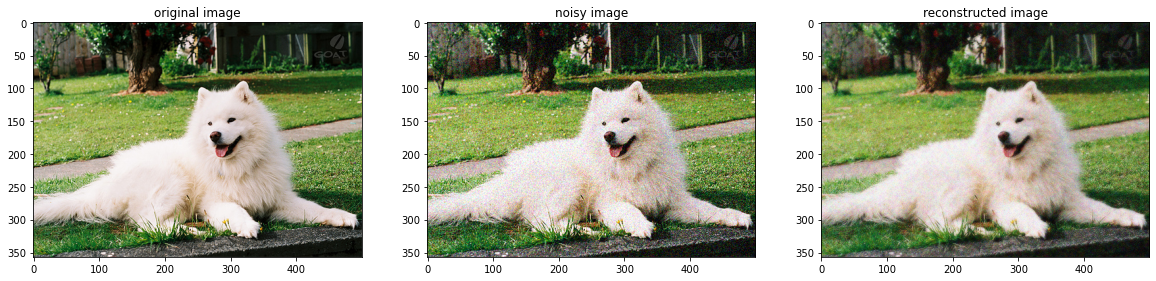

In [6]:
#Plotting results
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title("original image")
plt.subplot(132)
plt.imshow(noisy_img)
plt.title("noisy image")
plt.subplot(133)
plt.imshow(output_img)
plt.title("reconstructed image")
#Comparing psnr score
psnr_noisy=peak_signal_noise_ratio(img,noisy_img)
print("noisy psnr: ",psnr_noisy,"\n")
psnr_denoised=peak_signal_noise_ratio(img,output_img)
print("denoised psnr",psnr_denoised)
mse_noisy=mean_squared_error(img,noisy_img)
print("noisy mse: ",mse_noisy,"\n")
mse_denoised=mean_squared_error(img,output_img)
print("denoised mse",mse_denoised)

### B) Sparse Dictionary

#### i) implementation

In [7]:
def even_number_of_rows_and_columns(img):
    img2 = img.copy()
    if(img2.shape[0] %2 == 1):
        img2 = img2[:-1, :,:]
    if(img2.shape[1] %2 == 1):
        img2 = img2[:, :-1,:]
    return img2

### Getting noisy patches from the considere noisy image only
def get_noisy_patches_single_image(noisy_image,patch_size): 
    #Reshaping distorted image in a collection of patches, collected in dedicated array
    patches = extract_patches_2d(noisy_image, patch_size)
    patches = patches.reshape(patches.shape[0], -1)
    return (patches)

def learn_dictionary(noisy_patches,n_comp,non_zero_coeff,n_iter):
    #Mini-batch dictionnary Learning
    dico = MiniBatchDictionaryLearning(n_components=n_comp, 
                                        alpha=non_zero_coeff, 
                                        n_iter=n_iter)
    V = dico.fit(noisy_patches).components_
    return V, dico

def sparse_dict_method(noisy_image,patch_size = (8,8),non_zero_coeff = 2, n_comp = 100, n_iter = 500):
    
    noisy_patches= get_noisy_patches_single_image(noisy_image,patch_size)#extracting the patches on the noisy image
    dict_final, dico = learn_dictionary(noisy_patches,n_comp,non_zero_coeff,n_iter) #learning the dictionary on the noisy image
    dico.set_params(transform_algorithm='omp',transform_n_nonzero_coefs = non_zero_coeff)#setting parameters of dictionary
    code = dico.transform(noisy_patches) #Encode the data as a sparse combination of the dictionary atoms
    denoised_patches = np.dot(code,dict_final)
    #Reshaping the patches in the correct shape
    denoised_patches = (denoised_patches.reshape(noisy_patches.shape[0], patch_size[0], patch_size[1], 3))
    #Reconstructing the image from denoised patches
    image_denoised = reconstruct_from_patches_2d(denoised_patches, noisy_image.shape)
    image_denoised*=255 #denomrmalization
    image_denoised=image_denoised.astype('uint8')
    return image_denoised

#### ii) Test

In [8]:
path = './samoyed-data/'
name = 'samoyed-{}.jpg'.format(np.random.randint(200))
img = io.imread(path+name)
img = even_number_of_rows_and_columns(img)
noisy_img = addNoise(img,0.1)/255

In [9]:
output_img = sparse_dict_method(noisy_img)

<ipython-input-10-b1354a22a273>:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_noisy=peak_signal_noise_ratio(img,noisy_img)


noisy psnr:  5.831935340305726 

denoised psnr 26.76744316118466
noisy mse:  16978.011633832593 

denoised mse 136.87875449101796


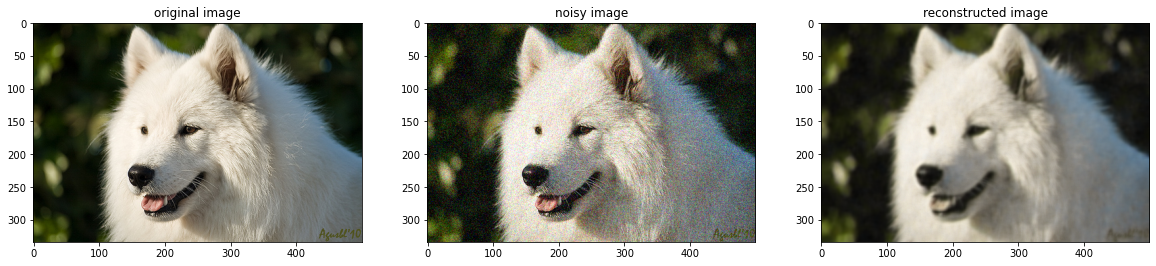

In [10]:
#Plotting results
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title("original image")
plt.subplot(132)
plt.imshow(noisy_img)
plt.title("noisy image")
plt.subplot(133)
plt.imshow(output_img)
plt.title("reconstructed image")

#Comparing psnr score
psnr_noisy=peak_signal_noise_ratio(img,noisy_img)
print("noisy psnr: ",psnr_noisy,"\n")
psnr_denoised=peak_signal_noise_ratio(img,output_img)
print("denoised psnr",psnr_denoised)
mse_noisy=mean_squared_error(img,noisy_img)
print("noisy mse: ",mse_noisy,"\n")
mse_denoised=mean_squared_error(img,output_img)
print("denoised mse",mse_denoised)

## II] Test of performance between the two methods

In [11]:
def load_data(id):
    path = './samoyed-data/'
    name = 'samoyed-{}.jpg'.format(id)
    img = io.imread(path+name) # to work with both method
    return img

def addNoise(img, sigma=0.05):
    h,w,d = img.shape
    noisy_img = np.copy(img)
    noise = np.array(sigma*np.random.randn(h,w)*255,dtype = 'uint8')
    for i in range(d):
         noisy_img[:,:,i] += noise
    return noisy_img

In [12]:
params = {}
params["nb_test"] = 10 # nb of image to test
params['sigma'] = 0.1 # standard deviation for the noise
######     NLM Parameters   ########
params["S"] = 10 # distance limit of the search for the NLM
params['s'] = 4 # size of the patch for the NLM
params['alpha'] = 14 # filtering parameter for the NLM
###### Sparse Dict Parameters ########
params["patch_size"] = (8,8) # size of the patches
params['non_zero_coeff'] = 2 # nbr of non zero coefficient in the sparse representation of a patch
params['n_comp'] = 100 # nbr of components in the dictionnary
params['n_iter'] = 500 # nbr of iteration to learn the dictionnary


In [13]:
def Tests(params):
    
    psnr_noisy = []
    psnr_denoised_nlm = []
    psnr_denoised_sd = []
    
    mse_noisy = []
    mse_denoised_nlm = []
    mse_denoised_sd = []
    n = params['nb_test']
    for id_img in tqdm(range(1,n+1)):
        img = load_data(id_img)
        noisy_img = addNoise(img,params['sigma'])
        psnr_noisy.append(peak_signal_noise_ratio(img,noisy_img))
        mse_noisy.append(mean_squared_error(img,noisy_img))
        
        # NLM
        output_img_nlm = NLM(noisy_img,params['S'],params['s'],params['alpha'])
        psnr_denoised_nlm.append(peak_signal_noise_ratio(img,output_img_nlm))
        mse_denoised_nlm.append(mean_squared_error(img,output_img_nlm))
        # Sparse dict
        output_img_sd = sparse_dict_method(noisy_img/255,params['patch_size'],params['non_zero_coeff'], params['n_comp'], params['n_iter'])
        psnr_denoised_sd.append(peak_signal_noise_ratio(img,output_img_sd))
        mse_denoised_sd.append(mean_squared_error(img,output_img_sd))
        
       
        
    return psnr_noisy,psnr_denoised_nlm,psnr_denoised_sd,mse_noisy,mse_denoised_nlm,mse_denoised_sd

In [14]:
psnr_noisy,psnr_denoised_nlm,psnr_denoised_sd,mse_noisy,mse_denoised_nlm,mse_denoised_sd = Tests(params)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.809e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.809e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571

C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.091e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.091e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.091e-

 40%|████████████████████████████████▊                                                 | 4/10 [17:19<25:52, 258.69s/it]C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.192e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.192e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\lucme\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:5

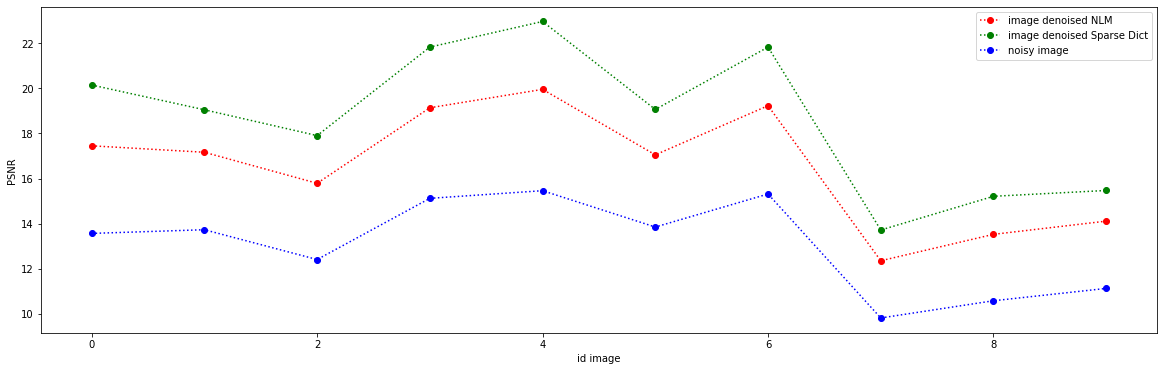

In [17]:
plt.figure(figsize=(20,6) )
plt.plot(psnr_denoised_nlm,'o:r', label='image denoised NLM')
plt.plot(psnr_denoised_sd,'o:g', label='image denoised Sparse Dict')
plt.plot(psnr_noisy,'o:b', label = 'noisy image')
plt.xlabel("id image")
plt.ylabel("PSNR")
plt.legend()
plt.show()

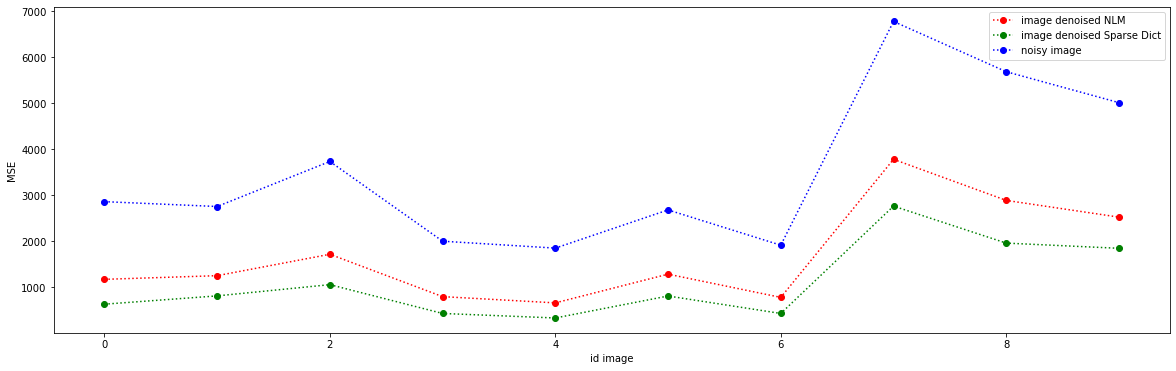

In [18]:
plt.figure(figsize=(20,6) )
plt.plot(mse_denoised_nlm,'o:r', label='image denoised NLM')
plt.plot(mse_denoised_sd,'o:g', label='image denoised Sparse Dict')
plt.plot(mse_noisy,'o:b', label = 'noisy image')
plt.xlabel("id image")
plt.ylabel("MSE")
plt.legend()
plt.show()